# Loading model

In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
models_dir = os.path.join(Path().resolve(),'trained_models','trained_models')
models = [f for f in os.listdir(models_dir) if f.find('ipynb')==-1]
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024_10_25 12-23-03 Deep Neural Network asian
1     2024_10_25 15-28-03 Deep Neural Network barrier_price
2     2024_10_25 16-04-54 Deep Neural Network asian


In [2]:
model = models[0]
model_dir = os.path.join(models_dir,model)
model_files = [f for f in os.listdir(model_dir) if f.find('ipynb')==-1]
for i,m in enumerate(model_files):
    print(f"{i}     {m}")

0     2024_10_25 12-23-03 Deep Neural Network asian insample.csv
1     2024_10_25 12-23-03 Deep Neural Network asian outsample.csv
2     2024_10_25 12-23-03 Deep Neural Network asian.pkl
3     2024_10_25 12-23-03 Deep Neural Network asian.txt


In [3]:
train_data = pd.read_csv(os.path.join(model_dir,model_files[0])).iloc[:,1:].copy()
test_data = pd.read_csv(os.path.join(model_dir,model_files[1])).iloc[:,1:].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'])
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'])
model_fit = joblib.load(os.path.join(model_dir,model_files[2]))
model_fit

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'kappa',
                                                                                        'theta',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0',
                                                                                        'fixing_frequency',
                                                                                        'n_fixings',
                                                                                        'past_fixings']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['averaging_type',
                                                                                        'w'])])),
                                                     ('regressor',
                                                      MLPRegressor(activation='tanh',
                                                                   hidden_layer_sizes=(15,
                                                                                       15,
                                                                                       15),
                                                                   learning_rate='adaptive',
                                                                   max_iter=1000,
                                                                   solver='lbfgs'))]),
                           transformer=Pipeline(steps=[('StandardScaler',
                                                        StandardScaler())]))

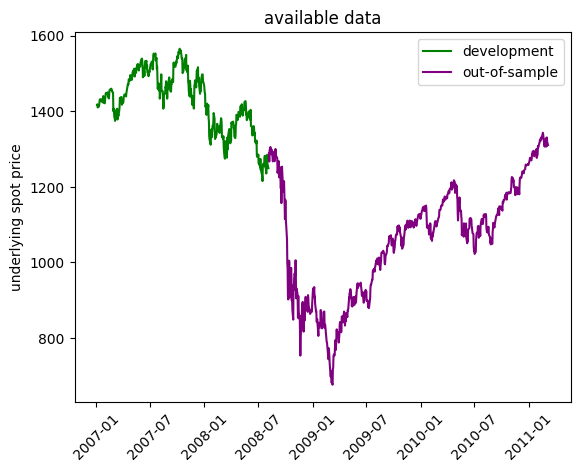

spot_price                       float64
strike_price                     float64
days_to_maturity                   int64
n_fixings                        float64
fixing_frequency                   int64
past_fixings                       int64
averaging_type                    object
w                                 object
risk_free_rate                   float64
dividend_rate                    float64
calculation_date          datetime64[ns]
kappa                            float64
theta                            float64
rho                              float64
eta                              float64
v0                               float64
asian                            float64
observed_price                   float64
outofsample_target               float64
outofsample_prediction           float64
outofsample_error                float64
dtype: object

In [4]:
train_spots = train_data[['calculation_date','spot_price']].copy().set_index('calculation_date').drop_duplicates().dropna()
test_spots = test_data[['calculation_date','spot_price']].copy().set_index('calculation_date').drop_duplicates().dropna()
train_dates = pd.Series(train_spots.index)
test_dates = pd.Series(test_spots.index)
plt.figure()
plt.plot(train_spots,color='green',label='development')
plt.plot(test_spots,color='purple',label='out-of-sample')
plt.title('available data')
plt.ylabel('underlying spot price')
plt.xticks(rotation=45)
plt.legend()
plt.show()
test_data.dtypes

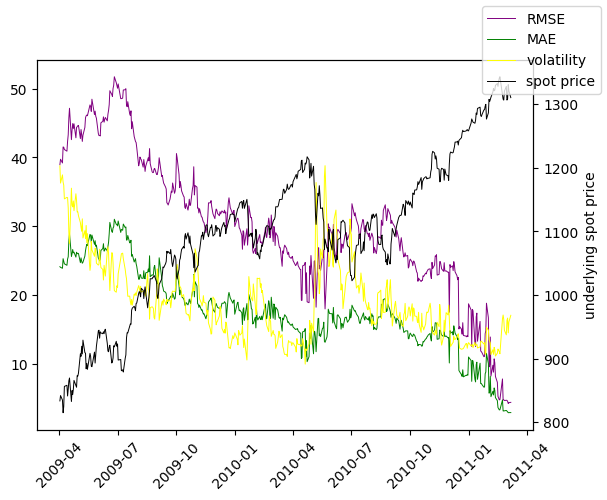

In [5]:
test_dates = test_dates[test_dates>pd.Timestamp(2009,4,1)]
test_spots = test_spots[test_spots.index.isin(test_dates)]
MAES = []
RMSES = []
vols = []
linew = 0.7

for i,date in enumerate(test_dates):
    df = test_data[test_data['calculation_date']==date].set_index('calculation_date')
    prediction = df['outofsample_prediction']
    target = df['observed_price']
    diff = prediction - target
    RMSES.append(np.sqrt(np.mean(diff**2)))
    MAES.append(np.mean(np.abs(diff)))
    vols.append(100*(float(df['v0'].unique()[0]))**(1/2))
    
fig, ax1 = plt.subplots()
plt.xticks(rotation=45)
ax2 = ax1.twinx()
MAES = np.array(MAES)
RMSES = np.array(RMSES)
vols = np.array(vols)
ax1.plot(test_dates,RMSES,color='purple',label='RMSE',linewidth=linew)
ax1.plot(test_dates,MAES,color='green',label='MAE',linewidth=linew)
ax1.plot(test_dates,vols,color='yellow',label='volatility',linewidth=linew)
ax2.plot(test_spots,color='black',label='spot price',linewidth=linew)
ax2.set_ylabel('underlying spot price')
fig.legend()
plt.show()

# Testing

In [6]:
from sklearn.linear_model import LinearRegression

R squared: 0.3369865076288605, intercept: 9.160607799531187 slope: 0.5645095147915072


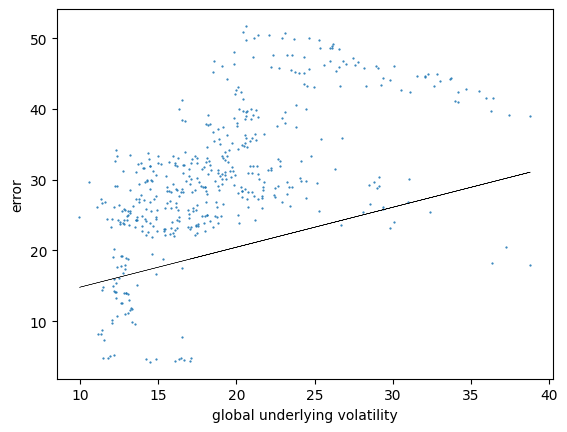

In [7]:
y = vols
X = MAES.reshape(-1,1)
reg = LinearRegression(fit_intercept=True).fit(X, y)
R2 = reg.score(X,y)
b1 = reg.coef_[0]
b0 = float(reg.intercept_)
print(f"R squared: {R2},",f"intercept: {b0}",f"slope: {b1}")
plt.figure()
plt.scatter(vols,RMSES,s=0.3)
plt.xlabel('global underlying volatility')
plt.ylabel('error')
plt.plot(vols,b0 + vols*b1,color='black',linewidth=0.3)
plt.show()

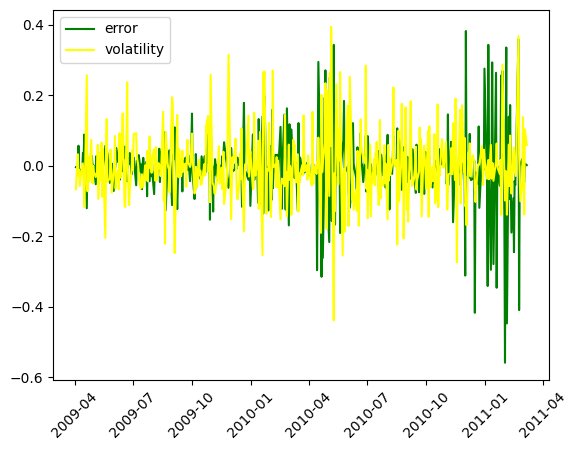

In [8]:
X = X.flatten()
lX = np.log(X)
dlX = lX[1:] - lX[:-1]
dlX = dlX.reshape(-1,1)

ly = np.log(y)
dly = ly[1:] - ly[:-1]

plt.figure()
plt.xticks(rotation=45)
plt.plot(test_dates[1:],dlX,color='green',label='error')
plt.plot(test_dates[1:],dly,color='yellow',label='volatility')
plt.legend()
plt.show()

R squared: 0.004533070394832972, intercept: 0.0 slope: -0.06977238817792536


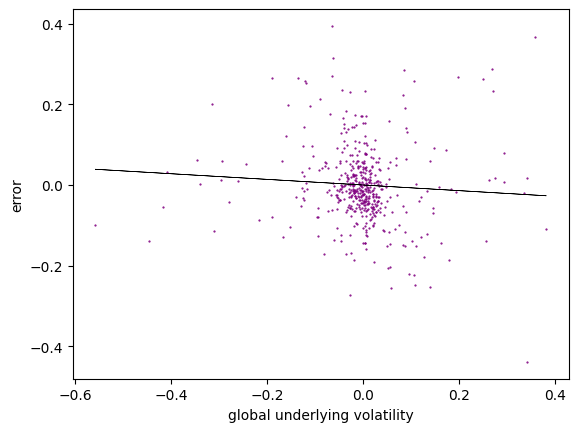

In [10]:
reg = LinearRegression(fit_intercept=False).fit(dlX, dly)
R2 = reg.score(dlX,dly)
b0 = reg.intercept_
b1 = reg.coef_[0]
print(f"R squared: {R2},",f"intercept: {b0}",f"slope: {b1}")

plt.figure()
plt.scatter(dlX,dly,s=0.3,color='purple')
plt.plot(dlX,b0+b1*dlX,linewidth=0.5,color='black')
plt.xlabel('global underlying volatility')
plt.ylabel('error')
plt.show()